#### MSDS 5511 - Final Assignment

The final evaluation for MSDS 5511 - Intro to deep learning is to provide a notebook
that demonstrates grasp of the subject matter and mastery.
I have chosen to utilize deep learning skills to train a cryptocurrency trading bot.

Brief Background: The cryptocurrency of focus is Ethereum and we will obtain the data from an online
 datasource. Data will be queried via Binance and manipulated w/ the technical analysis library.

Disclaimer: Do not use this model to trade and expect to make money. Trading crypto is highly volatile.


### Step 1: Grab data, perform EDA

In [21]:
asset = "ETH"  # ADA ETH LTC XRP EOS XLM XMR NEO   # All of these assets has sufficient data for training model
denominator = 'USDT'

# Parameters
wks= 15  # This parameter is for OOS timeframe
periods = 1  # 1
OutOfSamplePct = .25 # Train/Test Divider
InputLength = wks*168 # Out of sample length

# import packages
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
np.random.seed(42)
import pandas as pd
!pip install git+https://github.com/bukosabino/ta.git
!pip install arch==5.3.1
from arch import arch_model
import ta as ta
import pickle
import random
import os
import ta as ta
from sklearn.preprocessing import MinMaxScaler as scaler
scaler = scaler()
import time
from collections import deque
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Bidirectional, Flatten, LSTM, BatchNormalization
import warnings
warnings.simplefilter('ignore')

# Fetch historical data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from pandas import read_csv
link = 'https://www.cryptodatadownload.com/cdd/Binance_' + asset + denominator+'_1h.csv'
data = read_csv(link, sep=',', skiprows=[0])


  Cloning https://github.com/bukosabino/ta.git to c:\users\jefferya\appdata\local\temp\pip-req-build-u8t_mfun


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?
You should consider upgrading via the 'C:\Users\jefferya\PycharmProjects\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\jefferya\PycharmProjects\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.


 With Data imported, let's take a look at the dataset and make some inferences.


           unix                 date    symbol     open     high      low  \
0  1.660090e+12  2022-08-10 00:00:00  ETH/USDT  1702.76  1702.76  1689.10   
1  1.660086e+12  2022-08-09 23:00:00  ETH/USDT  1703.80  1711.04  1700.00   
2  1.660082e+12  2022-08-09 22:00:00  ETH/USDT  1706.69  1716.74  1697.01   
3  1.660079e+12  2022-08-09 21:00:00  ETH/USDT  1696.61  1711.18  1695.59   
4  1.660075e+12  2022-08-09 20:00:00  ETH/USDT  1688.01  1698.87  1687.40   

     close  Volume ETH   Volume USDT  tradecount  
0  1694.48  13460.7700  2.283749e+07     15898.0  
1  1702.76  20539.4071  3.501706e+07     23518.0  
2  1703.80  29642.9004  5.065355e+07     41419.0  
3  1706.70  32742.6704  5.580380e+07     52328.0  
4  1696.61  16441.2553  2.785455e+07     26615.0  
Last Date entry is:  2017-08-17 04-AM
<bound method NDFrame.describe of                unix                 date    symbol     open     high      low  \
0      1.660090e+12  2022-08-10 00:00:00  ETH/USDT  1702.76  1702.76  1689.10 

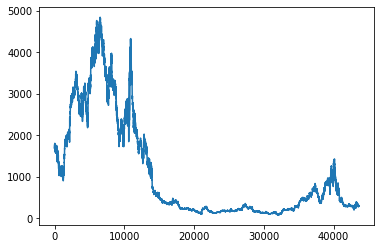

In [24]:
print(data.head(5))
print('Last Date entry is: ',data.date.values[-1])
plt.plot(data.close)


print(data.describe)

Firstly, The data has been imported backwards such that the last entry
is the most recent datapoint.
We will reverse the order of the dataset to correct this.
We can also see outright that there are some columns that are not benefiting the dataset,
we will remove these. I will drop date as well since the quantity will not
provide benefit to the model.

In [3]:
# Import Latest data and clean, append to historical (complete)
data = data[::-1]
data = data.reset_index(drop=True)
data = data.drop(['symbol', 'unix', 'date','tradecount'], axis=1)
AllData = data.drop([data.index[i] for i in range(500)])  # Drop first 500 rows due to fidelity issue
AllData = AllData.rename(columns={"Volume "+asset: "Volume"})
InputLength = wks*168

AllData.head(5)

,open,high,low,close,Volume,Volume USDT
500,335.00,335.01,332.25,332.25,128.59,42911.23
501,332.25,332.25,320.35,321.82,173.80,56704.38
502,321.82,328.98,321.08,325.20,248.23,80706.46
503,325.20,329.72,325.20,326.59,115.72,37865.40
504,326.59,329.31,325.41,328.32,39.14,12772.60


From an objective standpoint, we will seek to estimate the return on investment if we enter a long or short position in Ethereum. The target dataset will look like this:

$ Target(n) = Close(n+1) / Open(n+1) $

Based on the features at time n, the target is equal to the closing price of the next period divided by the opening of the next period. This is not typical and I'd like to explain the reasoning here. Typical models present the target as either the closing price at the next period or the percent difference of closing price at time n+1 divided by closing price of time n. Since we are using the features from each period to decide if we will take a position, we will not be able to enter that position until the subsequent time period. Furthermore, our return will not be realized until we close out the position at the end of the time period. Opening a position at the closing price of the current period is not practical and does not match the reality of the situation.

To make predictions of the target variable, we will need many more variables to train our model. The section below will create various technical indicators to be used for training. Broadly, the technical features I will introduce to the model involve indicators for momentum, price velocity, volume divergences, relative strength and volatility.

In [4]:
#Create Features for training
try:
    # RSI
    rsi14 = ta.momentum.RSIIndicator(close=AllData['close'], window=14, fillna=True)
    AllData['rsi14'] = rsi14.rsi()
    AllData['rsi14'] = scaler.fit_transform(AllData[["rsi14"]])
    rsi9 = ta.momentum.RSIIndicator(close=AllData['close'], window=9, fillna=True)
    AllData['rsi9'] = rsi9.rsi()
    AllData['rsi9'] = scaler.fit_transform(AllData[["rsi9"]])
    # MACD 5, 35, 5
    macd5355 = ta.trend.MACD(close=AllData['close'], window_slow=35, window_fast=5, window_sign=5, fillna=True)
    AllData['MACD5355macddiff'] = macd5355.macd_diff()
    AllData['MACD5355macddiffslope'] = macd5355.macd_diff().diff() # Slope of line
    AllData['MACD5355macddiff'][AllData['MACD5355macddiff'] >= 0] = 1
    AllData['MACD5355macddiff'][AllData['MACD5355macddiff'] < 0] = 0
    AllData['MACD5355macddiffslope'][AllData['MACD5355macddiffslope'] >= 0] = 1
    AllData['MACD5355macddiffslope'][AllData['MACD5355macddiffslope'] < 0] = 0

    AllData['MACD5355macd'] = macd5355.macd()
    AllData['MACD5355macdslope'] = macd5355.macd().diff()
    AllData['MACD5355macd'][AllData['MACD5355macd'] >= 0] = 1
    AllData['MACD5355macd'][AllData['MACD5355macd'] < 0] = 0
    AllData['MACD5355macdslope'][AllData['MACD5355macdslope'] >= 0] = 1
    AllData['MACD5355macdslope'][AllData['MACD5355macdslope'] < 0] = 0

    AllData['MACD5355macdsig'] = macd5355.macd_signal()
    AllData['MACD5355macdsigslope'] = macd5355.macd_signal().diff()
    AllData['MACD5355macdsig'][AllData['MACD5355macdsig'] >= 0] = 1
    AllData['MACD5355macdsig'][AllData['MACD5355macdsig'] < 0] = 0
    AllData['MACD5355macdsigslope'][AllData['MACD5355macdsigslope'] >= 0] = 1
    AllData['MACD5355macdsigslope'][AllData['MACD5355macdsigslope'] < 0] = 0
    # MACD 12,26,9
    macd12269 = ta.trend.MACD(close=AllData['close'], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    AllData['MACD12269macddiff'] = macd12269.macd_diff()
    AllData['MACD12269macddiffslope'] = macd12269.macd_diff().diff() # Slope of line
    AllData['MACD12269macddiff'][AllData['MACD12269macddiff'] >= 0] = 1
    AllData['MACD12269macddiff'][AllData['MACD12269macddiff'] < 0] = 0
    AllData['MACD12269macddiffslope'][AllData['MACD12269macddiffslope'] >= 0] = 1
    AllData['MACD12269macddiffslope'][AllData['MACD12269macddiffslope'] < 0] = 0

    AllData['MACD12269macd'] = macd12269.macd()
    AllData['MACD12269macdslope'] = macd12269.macd().diff()
    AllData['MACD12269macd'][AllData['MACD12269macd'] >= 0] = 1
    AllData['MACD12269macd'][AllData['MACD12269macd'] < 0] = 0
    AllData['MACD12269macdslope'][AllData['MACD12269macdslope'] >= 0] = 1
    AllData['MACD12269macdslope'][AllData['MACD12269macdslope'] < 0] = 0

    AllData['MACD12269macdsig'] = macd12269.macd_signal()
    AllData['MACD12269macdsigslope'] = macd12269.macd_signal().diff()
    AllData['MACD12269macdsig'][AllData['MACD12269macdsig'] >= 0] = 1
    AllData['MACD12269macdsig'][AllData['MACD12269macdsig'] < 0] = 0
    AllData['MACD12269macdsigslope'][AllData['MACD12269macdsigslope'] >= 0] = 1
    AllData['MACD12269macdsigslope'][AllData['MACD12269macdsigslope'] < 0] = 0

    # Engulfing Bars
    AllData['lowTail'] = AllData['low'].pct_change()
    AllData['lowTail'] = scaler.fit_transform(AllData[["lowTail"]])
    AllData['highTail'] = AllData['high'].pct_change()
    AllData['highTail'] = scaler.fit_transform(AllData[["highTail"]])
    AllData['openTail'] = AllData['open'].pct_change()
    AllData['openTail'] = scaler.fit_transform(AllData[["openTail"]])
    AllData['IntradayBar'] = (AllData.close.values[:] - AllData.open.values[:]) / AllData.open.values[:]
    AllData['IntradayBar'] = scaler.fit_transform(AllData[["IntradayBar"]])
    AllData['IntradayRange'] = (AllData.high.values[:] - AllData.low.values[:]) / AllData.low.values[:]
    AllData['IntradayRange'] = scaler.fit_transform(AllData[["IntradayRange"]])
    # SMA divergence
    for s in range(5, 200, 10):
        AllData['CloseOverSMA'+str(s)] = AllData['close'] / AllData['close'].rolling(window=s).mean()
        AllData['CloseOverSMA'+str(s)][AllData['CloseOverSMA'+str(s)] >= 1] = 1
        AllData['CloseOverSMA'+str(s)][AllData['CloseOverSMA'+str(s)] < 1] = 0
    # SMA Volume divergence
    for s in range(5, 220, 20):
        AllData['VolOverSMA'+str(s)] = AllData['Volume'] / AllData['Volume'].rolling(window=s).mean()
        AllData['VolOverSMA'+str(s)][AllData['VolOverSMA'+str(s)] >= 1] = 1
        AllData['VolOverSMA'+str(s)][AllData['VolOverSMA'+str(s)] < 1] = 0


    # Recent Performance
    AllData['Ret1day'] = AllData['close'].pct_change(1)
    AllData['Ret1day'] = scaler.fit_transform(AllData[["Ret1day"]])
    AllData['Ret4day'] = AllData['close'].pct_change(4)
    AllData['Ret4day'] = scaler.fit_transform(AllData[["Ret4day"]])
    AllData['Ret8day'] = AllData['close'].pct_change(8)
    AllData['Ret8day'] = scaler.fit_transform(AllData[["Ret8day"]])
    AllData['Ret12day'] = AllData['close'].pct_change(12)
    AllData['Ret12day'] = scaler.fit_transform(AllData[["Ret12day"]])
    AllData['Ret24day'] = AllData['close'].pct_change(24)
    AllData['Ret24day'] = scaler.fit_transform(AllData[["Ret24day"]])
    AllData['Ret72day'] = AllData['close'].pct_change(72)
    AllData['Ret72day'] = scaler.fit_transform(AllData[["Ret72day"]])
    AllData['Ret240day'] = AllData['close'].pct_change(240)
    AllData['Ret240day'] = scaler.fit_transform(AllData[["Ret240day"]])
    # BBs
    BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=30)
    AllData['bandsGap30'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
    # Replace infs with last non-inf entry
    try:
        infs = AllData['bandsGap30'][np.isinf(AllData['bandsGap30']) == True].iloc
        for u in infs[:].index[:].values:
            AllData['bandsGap30'][u] = AllData['bandsGap30'][u-1]
    except:
        1
    AllData['bandsGap30'] = scaler.fit_transform(AllData[["bandsGap30"]])

    BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=100)
    AllData['bandsGap100'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
    # Replace infs with last non-inf entry
    try:
        infs = AllData['bandsGap100'][np.isinf(AllData['bandsGap100']) == True].iloc
        for u in infs[:].index[:].values:
            AllData['bandsGap100'][u] = AllData['bandsGap100'][u-1]
    except:
        1
    AllData['bandsGap100'] = scaler.fit_transform(AllData[["bandsGap100"]])

    BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=200)
    AllData['bandsGap200'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
    # Replace infs with last non-inf entry
    try:
        infs = AllData['bandsGap200'][np.isinf(AllData['bandsGap200']) == True].iloc
        for u in infs[:].index[:].values:
            AllData['bandsGap200'][u] = AllData['bandsGap200'][u-1]
    except:
        1
    AllData['bandsGap200'] = scaler.fit_transform(AllData[["bandsGap200"]])
    
    # ADX
    ADX = ta.trend.ADXIndicator(high=AllData['high'], low=AllData['low'], close=AllData['close'], window=14,
                                fillna=True)
    AllData['ADX'] = ADX.adx()
    AllData['ADX'] = scaler.fit_transform(AllData[["ADX"]])

    # Ichimoku Clouds
    ICH = ta.trend.IchimokuIndicator(high=AllData['high'], low=AllData['low'], fillna=True)
    AllData['closeVsIchA'] = AllData['close'] / ICH.ichimoku_a()
    AllData['closeVsIchA'] = scaler.fit_transform(AllData[["closeVsIchA"]])
    AllData['closeVsIchB'] = AllData['close'] / ICH.ichimoku_b()
    AllData['closeVsIchB'] = scaler.fit_transform(AllData[["closeVsIchB"]])
    AllData['IchAvIchB'] = ICH.ichimoku_a() / ICH.ichimoku_b()
    AllData['IchAvIchB'] = scaler.fit_transform(AllData[["IchAvIchB"]])
    # # Garch volatility forecast

    AllData = AllData.dropna(axis=0,how='any')
    am = arch_model(AllData['Ret1day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_1'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret4day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_4'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret8day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_8'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret12day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_12'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret24day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_24'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret72day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_72'] = res.conditional_volatility.values.reshape(-1,1)

    am = arch_model(AllData['Ret240day'])
    res = am.fit(update_freq=1)
    AllData['CondVol_240'] = res.conditional_volatility.values.reshape(-1,1)

    AllData['CondVol_1'] = scaler.fit_transform(AllData[['CondVol_1']])
    AllData['CondVol_4'] = scaler.fit_transform(AllData[['CondVol_4']])
    AllData['CondVol_8'] = scaler.fit_transform(AllData[['CondVol_8']])
    AllData['CondVol_12'] = scaler.fit_transform(AllData[['CondVol_12']])
    AllData['CondVol_24'] = scaler.fit_transform(AllData[['CondVol_24']])
    AllData['CondVol_72'] = scaler.fit_transform(AllData[['CondVol_72']])
    AllData['CondVol_240'] = scaler.fit_transform(AllData[['CondVol_240']])


    # Volume by Price (+/-) 5% in the last 72 periods
    bins = 7
    binRange = .05
    duration = 72
    # holding array
    binnedData = np.zeros((AllData.__len__(), bins))
    for t in range(duration, AllData.__len__()):
        # Determine Price Range
        priceRange = np.linspace(AllData.close.values[t] * (1 - binRange), AllData.close.values[t] * (1 + binRange), bins)
        for j in range(1, len(priceRange)):
            binnedData[t, j] = sum(AllData['Volume'][t - duration:t][(AllData.close[t - duration:t] <= priceRange[j]) &
                                                                  (AllData.close[t - duration:t] >= priceRange[
                                                                      j - 1])])
        binnedData[t, :] = binnedData[t, :] / binnedData[t, :].max()
    for j in range(1, bins):
        AllData['bin' + str(j)] = binnedData[:, j]

    # Clean up output
    InputData = AllData[-InputLength:]
    AllData = AllData.dropna(axis=0, how='any')
    # If conditions are met, you can move the data to a list

        # For saving in process. If it freezes you can restart later with pkl files
    with open('BinanceAllDataForRL.pkl', 'wb') as f:
        pickle.dump(AllData, f)
    with open('BinanceInputDataForRL.pkl', 'wb') as f:
        pickle.dump(InputData, f)
except:
    1


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2223524551780326e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.328477784556272e+21
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1.3068895149291593e+29
Iteration:      4,   Func. Count:     47,   Neg. LLF: 9.929502144816435e+29
Iteration:      5,   Func. Count:     62,   Neg. LLF: 18835681830.204945
Iteration:      6,   Func. Count:     70,   Neg. LLF: 24774063040.730747
Iteration:      7,   Func. Count:     79,   Neg. LLF: 8.38639464237943e+22
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4987.767657509755
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4987.7681511669
            Iterations: 12
            Function evaluations: 89
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 41340808.986172386
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95539.60268614008
            I

c:\users\jefferya\pycharmprojects\pythonproject\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Here are some plots of the scaled data. We have used a Min Max scaler so all features should be scaled between 0 & 1.


Text(0.5, 1.0, 'RSI 14 period')

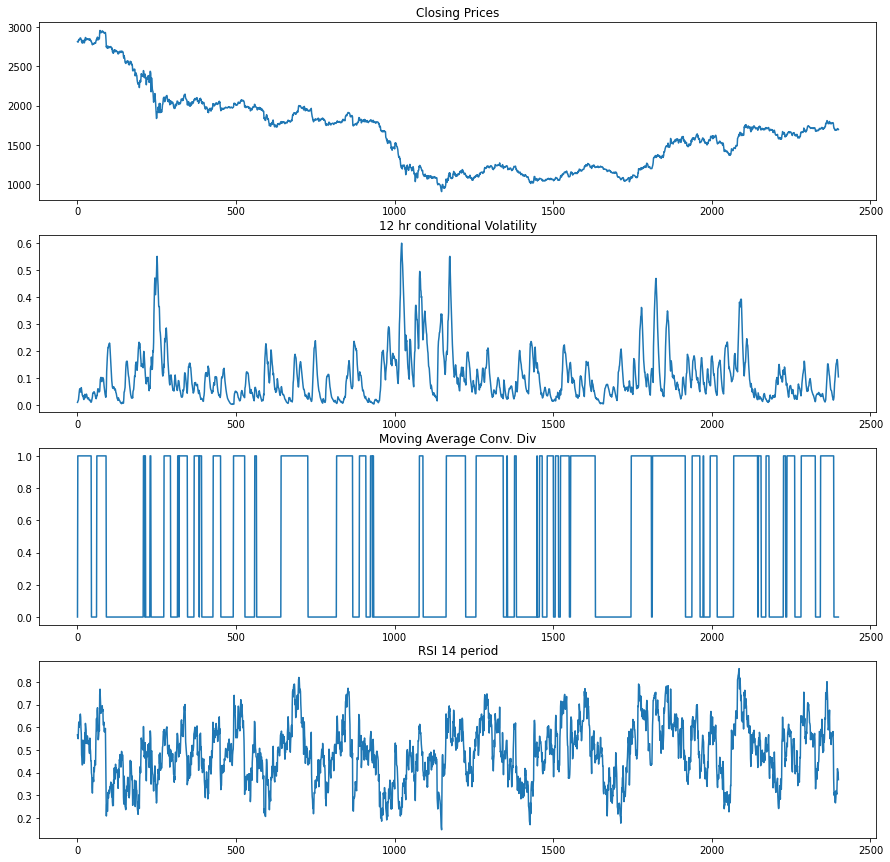

In [5]:
from IPython.core.pylabtools import figsize
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1)
fig.set_figheight(15)
fig.set_figwidth(15)

ax0.plot(AllData.close.values[-2400:])
ax0.set_title('Closing Prices')

ax1.plot(AllData['CondVol_12'].values[-2400:])
ax1.set_title('12 hr conditional Volatility')

ax2.plot(AllData['MACD12269macd'].values[-2400:])
ax2.set_title('Moving Average Conv. Div')

ax3.plot(AllData['rsi14'].values[-2400:])
ax3.set_title('RSI 14 period')


Our motivation will be to use these variables as input features to a sequential model.


#### Step 2: Build a Network and train

The task is predicting on sequential data, therefore a recurrent neural network is preferrable.
I have chosen to stack multiple Bidirectional LSTMs for my network.
At the output of the network I will use a series of dense fully connected layers to condense the LSTM output. Finally, a single neuron dense layer will be utilized to make predictions.

We have 90 training features, of which some may not be adding value to the mode. To address this, I will implement Principal component analysis (PCA henceforth) to compress the features down to a more managable size with a known proportion of overall variance. I have chosen 90% total variance for PCA compression. This greatly shinks the model data down.

Because the target data roughly resembles a gaussian distribution (yes, I know that crypto assets are non gaussian and have both fat tails as well as a general bias to positive values). Since the data has both postive and negative values, I will use a tanh function for the single neuron output. Essentially the network is predicting proportion of long or short.

Lastly, and this came with a great deal of experimentation, the loss function needs to be considered specifically. Simply using MSE or MAE produces mixed results. A MSE model simply learns to predict the mean value of the distribution and fails to take directional positions on the input data. Mean absolute error is comparable in this regard. Because of this, I have designed a loss function that seeks to maximize profit while minimizing volatility of positions. The loss function has academic lineage and is commonly referred to as the Sharpe's ratio.

$ Sharpes Ratio = mean(Returns)/std(Returns)  $

source: 
https://en.wikipedia.org/wiki/Sharpe_ratio#:~:text=In%20finance%2C%20the%20Sharpe%20ratio,after%20adjusting%20for%20its%20risk.

For this evaluation, I will first train a model with MSE as loss and then introduce the custom loss function w/ Sharpe's ratio as the objective. We will have subsequent discussion to evaluate which training method works best.

In [6]:
from tensorflow.keras.layers import Dense, Bidirectional, Flatten, LSTM, BatchNormalization

LSTM_Neurons = 60
SEQ_LEN = 12
Stacks = 1
lr = 2.5e-5
alpha= 1
batchSize = 64
DropoutVal = .25
EPOCHS = 35

'''Import data as dataframe'''
AllData = pickle.load(open("BinanceAllDataForRL.pkl", "rb"))
InputData = pickle.load(open("BinanceInputDataForRL.pkl", "rb"))

directory = os.getcwd()
# !nvidia-smi
#
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


# Essential Functions
def preprocess_df(df, OutOfSamplePct):
    df = df.drop(['close', 'open', 'high', 'low', 'Volume', 'Volume '+denominator], 1)
    df.dropna(inplace=True)

    from sklearn.decomposition import PCA
    model = PCA(n_components=20)
    model.fit(df)
    ExpVar = np.cumsum(model.explained_variance_ratio_)
    comps = len(ExpVar[ExpVar <= 0.9])  # 0.5
    print('Components: ', comps)
    df = model.transform(df)
    df=pd.DataFrame(df[:,:comps])

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1:]])

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    testcutoff = np.int((1-OutOfSamplePct)*len(sequential_data))
    # For exporting
    for seq, target in sequential_data[:testcutoff]:
        X_train.append(seq)
        y_train.append(target)
    for seq, target in sequential_data[testcutoff:]:
        X_test.append(seq)
        y_test.append(target)
    ''' Output Section'''
    # Pickle the model and comps
    with open('pca.pkl', 'wb') as f:
      pickle.dump(model, f, protocol=2)
    with open('comps.pkl', 'wb') as f:
      pickle.dump(comps, f, protocol=2)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), model, comps

def preprocess_df_pred(df, model, comps):
    # df = df.drop(['close', 'open', 'high', 'low', 'Volume', 'Volume '+denominator, 'WasUp'], 1)
    df = df.drop(['close', 'open', 'high', 'low', 'Volume', 'Volume '+denominator], 1)
    df.dropna(inplace=True)
    ''' Extra Prediction Data'''
    df = model.transform(df)
    df=pd.DataFrame(df[:,:comps])
    
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values: 
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1:]])
    X_pred = []
    y_pred = []
    for seq, target in sequential_data:
        X_pred.append(seq)
        y_pred.append(target)
    return np.array(X_pred), np.array(y_pred)

# Experimental Past/Present Predictor
# Grab data & Run model
IndLength = len(AllData)
mainholder = []
Length = np.shape(AllData.close)
WasUp = np.nan * (np.zeros(Length))
WasUp[:-periods] = AllData.close.values[periods:] / AllData.open.values[1:Length[0] - periods + 1]
AllData['WasUp'] = WasUp - 1

# Test/Train data that has zero overlap w/ OOS data (InputData)
AllData = AllData[:-InputLength]

# WasUp Target Variable
Length = np.shape(InputData.close)
WasUp = np.nan * (np.zeros(Length))
WasUp[:-periods] = InputData.close.values[periods:] / InputData.open.values[1:Length[0] - periods + 1]
InputData['WasUp'] = WasUp - 1
      
InputLabels=AllData.columns
Val_InputLabels=InputData.columns
times = sorted(AllData.index.values)
last_5pct = -int(OutOfSamplePct * len(AllData))
testcutoff = times[last_5pct]

MainHolder = []  # For export data
AllData = AllData.dropna(axis=0, how="any")
InputData = InputData.dropna(axis=0, how="any")

X_train, y_train, X_test, y_test, model, comps = preprocess_df(AllData, OutOfSamplePct)
X_pred, y_pred = preprocess_df_pred(InputData, model, comps)

# Custom Loss function
def custom_loss_function(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   sh = tf.math.reduce_mean(positions)/tf.math.reduce_std(positions)  # Sharps
   return -sh

# Custom Metric function
def custom_metric_function(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   sh = tf.math.reduce_mean(positions)/tf.math.reduce_std(positions)  # Sharps
   return -sh

# Custom Metric function 2
def custom_metric_function2(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   r = tf.math.reduce_mean(positions)
   return r

# Build Residual model
input = tf.keras.Input(shape=(SEQ_LEN, X_train.shape[2]))
x = Bidirectional(LSTM(LSTM_Neurons, activation='tanh', return_sequences=True, dropout=DropoutVal,kernel_initializer='he_uniform'))(input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
out = Dense(1,activation='tanh')(x)

model = tf.keras.models.Model(inputs=input, outputs=out)
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=opt,
    metrics=[custom_metric_function2],
    loss='mse',
    )

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=batchSize,
                    verbose=1,
                    use_multiprocessing=False,
                    workers=1,
                    shuffle=True,
                    )


Components:  14
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 13)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 12, 120)           35520     
_________________________________________________________________
flatten (Flatten)            (None, 1440)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1440)              5760      
_________________________________________________________________
dense (Dense)                (None, 256)               368896    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)     

Let's look at how the validation data generalized vs. the training data.

NOTE: there is a curious feature of the validation loss history. we observe that the validation set has lower loss than the training loss. I have double checked the data and can confirm it's authenticity. My guess is that the patterns the model trained on are more pronounced in the test set.

Text(0.5, 0, 'Epoch')

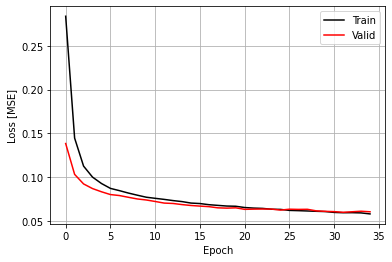

In [8]:
plt.plot(history.history['loss'],'k')
plt.plot(history.history['val_loss'],'r')
plt.grid()
plt.legend(['Train','Valid'])
plt.ylabel('Loss [MSE]')
plt.xlabel('Epoch')

Visualize how the OOS data performs compared to the Train and Validation datasets.

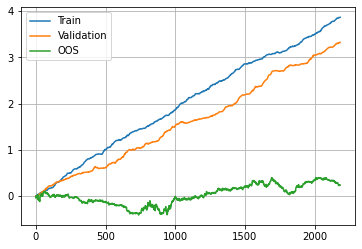

In [9]:
mytime= 13  # One Quarter of a year for OOS

X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

X_train_pred[X_train_pred>0] = 1
X_train_pred[X_train_pred<0] = -1

X_test_pred[X_test_pred>0] = 1
X_test_pred[X_test_pred<0] = -1

y_true = InputData.WasUp
y_pred = model.predict(X_pred)

y_pred[y_pred>0] = 1
y_pred[y_pred<0] = -1

outcome = [num1*num2 for num1, num2 in zip(y_true[-168*mytime:].values,y_pred[-168*mytime:,0])]
outcome1 = [num1*num2 for num1, num2 in zip(y_train[-168*mytime:],X_train_pred[-168*mytime:,0])]
outcome2 = [num1*num2 for num1, num2 in zip(y_test[-168*mytime:],X_test_pred[-168*mytime:,0])]

plt.plot(np.cumsum(outcome1)/100)
plt.plot(np.cumsum(outcome2)/100)
plt.plot(np.cumsum(outcome))
plt.legend(['Train','Validation','OOS'])
plt.grid()


Let's see the Out of Sample returns for the network.

OOS data (Green) is for the last 13 weeks of 'live testing' the data. The model was trained on data prior to this timeframe and we want to see if we would have actually made money if we invested in accordance with this model. We can see that the green line lacks the overall shape of the blue (train) and orange (validation) data.

The chart is somewhat vague. We can see that the end point is a
modest gain if we had gone with the model,
but we don't know how this compares to the alternative of either
 not investing (zero return) or simply buying Ethereum and holding.
  We will next look at how the model performed against a strategy of
   simply holding ETH for the last 13 weeks.

predictedY (2184,)
actualY (2184,)
Strategy Omniscience:  0.014221797587931571
50.183 % Accurate
All Returns:  24.39161406281635 %
Average Win: 0.7935575663154145 %
Average Loss: -0.776973785495292 %
Exp. Ret: 0.780370010424214 %
Sharpe's Ratio: 0.009382355525285282


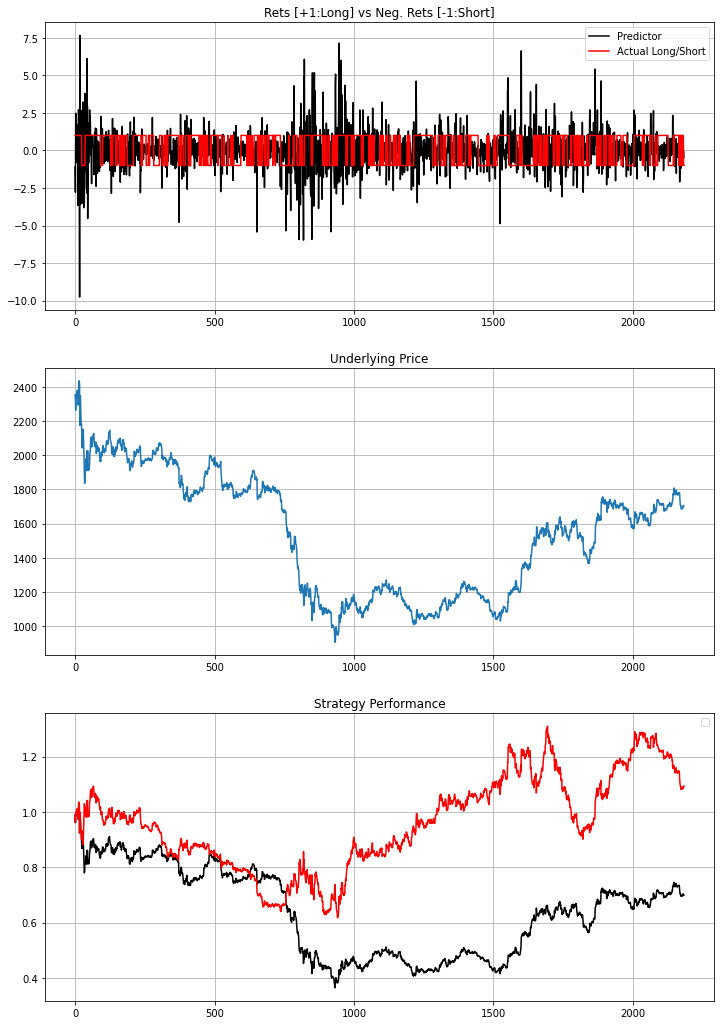

In [10]:
# Check model Performance against benchmark

PredictedY = model.predict(X_pred)

import copy

myTime = 13
PredictedY=PredictedY[-168*myTime:,0]

PredictedY[PredictedY>0] = 1
PredictedY[PredictedY<0] = -1

ActualY = copy.deepcopy(InputData.WasUp.values[-168*myTime:])

c=0
print('predictedY',np.shape(PredictedY))
print('actualY',np.shape(ActualY))

Strategy = np.array([num1*num2 for num1, num2 in zip(ActualY[:], PredictedY[:])])

Omniscience = sum(Strategy)/sum(abs(ActualY))
print('Strategy Omniscience: ', Omniscience) 
for i in range(len(PredictedY)):
  if (PredictedY[i] >= 0 and ActualY[i] >= 0) or (PredictedY[i] < 0 and ActualY[i] < 0):
    c+=1
print(np.round_(100*c/len(PredictedY),3),'% Accurate')

fig = plt.gcf()
fig.set_size_inches(12, 18)
plt.subplot(3,1,1)
plt.plot(100*ActualY[-myTime*168:],'k')
plt.plot(PredictedY[-myTime*168:],'r')
plt.grid()
plt.legend(['Predictor','Actual Long/Short'])
plt.title('Rets [+1:Long] vs Neg. Rets [-1:Short]')

PredictedY = PredictedY[-myTime*168:]
ActualY = copy.deepcopy(InputData.WasUp[-myTime*168:].values)

plt.subplot(3,1,2)
plt.title('Underlying Price')
plt.plot(InputData.close.values[-myTime*168:])
plt.grid()
# plt.title('Cum. Returns of All 12hr holding periods')
plt.subplot(3,1,3)
plt.title('Strategy Performance')
plt.plot(np.cumprod(1+ActualY),'k')
plt.plot(np.cumprod(1+Strategy),'r')
plt.legend('Actual','Strategy')
plt.grid()


print('All Returns: ', 100*sum(Strategy)/periods,'%')
# print('Average Returns: ', 100*np.mean(ActualY),'%')
print('Average Win:', 100*np.mean(Strategy[Strategy >= 0]),'%')
print('Average Loss:', 100*np.mean(Strategy[Strategy < 0]),'%')
prob = np.round_(100*c/len(PredictedY),3)
ExpRet = (prob*np.mean(Strategy[Strategy >= 0]) + (1-prob)*np.mean(Strategy[Strategy < 0]))
print("Exp. Ret:", ExpRet,'%')
print("Sharpe's Ratio:", (sum(Strategy)/len(Strategy))/(np.std(Strategy)))

The Model trained with a MSE loss function does not instill a since of strong confidence against historical data (see above). It performs in line with the benchmark. 

#### Enhanced model approach

We have not yet tried the custom loss function that is intended to maximize average return while minimizing the standard deviation of the returns.

We will retrain with some additions to the network:
- Additional LSTM layers
- Adding additional neurons to the layers
- Adding Early stopping
- Adding checkpoints to save intermediate models and load the best model after training
- Increase the input sequence length 4x

We will train the network and evalaute the performance in the same manner we just did for the basic network with MSE loss and minimal LSTM architecture.

In [14]:
LSTM_Neurons = 80
SEQ_LEN = 64
patience = 10
lr = 3.2e-5
alpha= 1
batchSize = 48
DropoutVal = .20
EPOCHS = 15

'''Import data as dataframe'''
AllData = pickle.load(open("BinanceAllDataForRL.pkl", "rb"))
InputData = pickle.load(open("BinanceInputDataForRL.pkl", "rb"))

directory = os.getcwd()
# !nvidia-smi
#
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


# Essential Functions
def preprocess_df(df, OutOfSamplePct):
    df = df.drop(['close', 'open', 'high', 'low', 'Volume', 'Volume '+denominator], 1)
    df.dropna(inplace=True)

    from sklearn.decomposition import PCA
    model = PCA(n_components=20)
    model.fit(df)
    ExpVar = np.cumsum(model.explained_variance_ratio_)
    comps = len(ExpVar[ExpVar <= 0.9])
    print('Components: ', comps)
    df = model.transform(df)
    df=pd.DataFrame(df[:,:comps])

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1:]])

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    testcutoff = np.int((1-OutOfSamplePct)*len(sequential_data))
    # For exporting
    for seq, target in sequential_data[:testcutoff]:
        X_train.append(seq)
        y_train.append(target)
    for seq, target in sequential_data[testcutoff:]:
        X_test.append(seq)
        y_test.append(target)
    ''' Output Section'''
    # Pickle the model and comps
    with open('pca.pkl', 'wb') as f:
      pickle.dump(model, f, protocol=2)
    with open('comps.pkl', 'wb') as f:
      pickle.dump(comps, f, protocol=2)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), model, comps

def preprocess_df_pred(df, model, comps):
    df = df.drop(['close', 'open', 'high', 'low', 'Volume', 'Volume '+denominator], 1)
    df.dropna(inplace=True)
    ''' Extra Prediction Data'''
    df = model.transform(df)
    df=pd.DataFrame(df[:,:comps])
    
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)

    for i in df.values: 
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1:]])
    X_pred = []
    y_pred = []
    for seq, target in sequential_data:
        X_pred.append(seq)
        y_pred.append(target)
    return np.array(X_pred), np.array(y_pred)

# Experimental Past/Present Predictor
# Grab data & Run model
IndLength = len(AllData)
mainholder = []
Length = np.shape(AllData.close)
WasUp = np.nan * (np.zeros(Length))
WasUp[:-periods] = AllData.close.values[periods:] / AllData.open.values[1:Length[0] - periods + 1]
AllData['WasUp'] = WasUp - 1

# Test/Train data that has zero overlap w/ OOS data (InputData)
AllData = AllData[:-InputLength]

# WasUp Target Variable
Length = np.shape(InputData.close)
WasUp = np.nan * (np.zeros(Length))
WasUp[:-periods] = InputData.close.values[periods:] / InputData.open.values[1:Length[0] - periods + 1]
InputData['WasUp'] = WasUp - 1
      
InputLabels=AllData.columns
Val_InputLabels=InputData.columns
times = sorted(AllData.index.values)
last_5pct = -int(OutOfSamplePct * len(AllData))
testcutoff = times[last_5pct]

MainHolder = []  # For export data
AllData = AllData.dropna(axis=0, how="any")
InputData = InputData.dropna(axis=0, how="any")

X_train, y_train, X_test, y_test, model, comps = preprocess_df(AllData, OutOfSamplePct)
X_pred, y_pred = preprocess_df_pred(InputData, model, comps)

# Custom Loss function
def custom_loss_function(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   ## Omniscience performs the best
   sh = tf.math.reduce_mean(positions)/tf.math.reduce_std(positions)  # Sharps
   return -sh

# Custom Metric function
def custom_metric_function(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   sh = tf.math.reduce_mean(positions)/tf.math.reduce_std(positions)  # Sharps
   return -sh

# Custom Metric function 2
def custom_metric_function2(y_true, y_pred):
   positions = tf.math.multiply(y_true, y_pred)
   r = tf.math.reduce_mean(positions)
   return r

# Build Residual model
input = tf.keras.Input(shape=(SEQ_LEN, X_train.shape[2]))
x = Bidirectional(LSTM(LSTM_Neurons, activation='tanh', return_sequences=True, dropout=DropoutVal,kernel_initializer='he_uniform'))(input)
x = Bidirectional(LSTM(LSTM_Neurons, activation='tanh', return_sequences=True, dropout=DropoutVal,kernel_initializer='he_uniform'))(x)
# x = tf.keras.layers.add([x, x_rnn])
# x = Bidirectional(LSTM(np.int(LSTM_Neurons*alpha), activation='tanh', return_sequences=True, dropout=DropoutVal,kernel_initializer='he_uniform'))(x)

x = Flatten()(x)
x = BatchNormalization()(x)
# x = Dense(512,activation='tanh')(x)  # 512
# x = BatchNormalization()(x)
x = Dense(256,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(128,activation='tanh')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='tanh')(x)
x = BatchNormalization()(x)
out = Dense(1,activation='tanh')(x)

model = tf.keras.models.Model(inputs=input, outputs=out)
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# Checkpoint

filepath = 'AllStocks' + "-{epoch:02d}-{val_custom_metric_function:.10f}"
checkpoint = ModelCheckpoint(
    "models/{}.model".format(filepath, monitor='val_custom_metric_function', verbose=1, save_best_only=True,
                             save_weights_only=False,
                             mode='min'))
# EarlyStopping
ES = EarlyStopping(monitor='val_custom_metric_function', mode='min', patience=patience)

model.compile(
    optimizer=opt,
    metrics=[custom_metric_function,custom_metric_function2],
    loss=custom_loss_function,
    )

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=batchSize,
                    callbacks=[ES, checkpoint],
                    verbose=1,
                    use_multiprocessing=False,
                    workers=1,
                    shuffle=True,
                    )

'''saving model and OOS metrics'''
# Identify the best model
# (Maximal Accuracy)
tix = 'AllStocks'
for root, dirs, files in os.walk(os.getcwd() + '/models/'):
    def find(s, ch):
        return [id for id, ltr in enumerate(s) if ltr == ch]
    acc0 = .0
    for name in dirs:
        if name[0:len(tix)] == tix:  # File pertains to specific industry
            dashSpot = []
            dashSpot = find(name, "-")
            acc = float(name[dashSpot[1] + 1:dashSpot[1] + 13])
            if acc <= acc0:
                acc0 = acc
                bestfilename = name

# Load the best model
model = tf.keras.models.load_model(os.getcwd() + '/models/' + bestfilename, compile=False)
os.rename(os.getcwd() + '/models/' + bestfilename,
          os.getcwd() + "/models/BestModel")

# Export Model to Local drive
# !zip -r /content/BestModel.zip /content/models/BestModel
# from google.colab import files
# files.download("/content/BestModel.zip")
# files.download("/content/pca.pkl")
# files.download("/content/comps.pkl")

opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer=opt,
    loss=custom_loss_function,
    metrics='custom_metric_function')


Components:  14
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 13)]          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64, 160)           60160     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64, 160)           154240    
_________________________________________________________________
flatten_2 (Flatten)          (None, 10240)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10240)             40960     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2621696   
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)   

INFO:tensorflow:Assets written to: models\AllStocks-01--0.3875956833.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-02--0.4360542893.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-03--0.4734488428.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-04--0.4490542412.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-05--0.4727424681.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-06--0.4831050932.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-07--0.4585203230.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-08--0.4797372818.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-09--0.4736749530.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-10--0.4761075675.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-11--0.4599405229.model\assets
INFO:tensorflow:Assets written to: models\AllStocks-12--0.4981284142.model\assets
INFO:tensorflow:

Let's see how the deeper model compares against the Train and validation datasets.

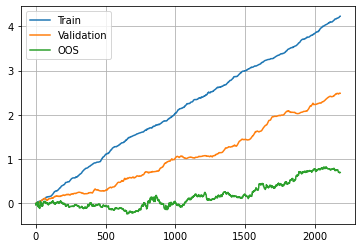

In [15]:
mytime= 13  # One Quarter of a year for OOS

X_train_pred = model.predict(X_train)
X_test_pred = model.predict(X_test)

X_train_pred[X_train_pred>0] = 1
X_train_pred[X_train_pred<0] = -1

X_test_pred[X_test_pred>0] = 1
X_test_pred[X_test_pred<0] = -1

y_true = InputData.WasUp
y_pred = model.predict(X_pred)

y_pred[y_pred>0] = 1
y_pred[y_pred<0] = -1

outcome = [num1*num2 for num1, num2 in zip(y_true[-168*mytime:].values,y_pred[-168*mytime:,0])]
outcome1 = [num1*num2 for num1, num2 in zip(y_train[-168*mytime:],X_train_pred[-168*mytime:,0])]
outcome2 = [num1*num2 for num1, num2 in zip(y_test[-168*mytime:],X_test_pred[-168*mytime:,0])]

plt.plot(np.cumsum(outcome1)/100)
plt.plot(np.cumsum(outcome2)/100)
plt.plot(np.cumsum(outcome))
plt.legend(['Train','Validation','OOS'])
plt.grid()

We can see that the Green line for OOS trading has a generally positive slope.
It seems that the deeper network w/ custom loss produces better results than the first model
on live data (OOS).

predictedY (2184,)
actualY (2184,)
Strategy Omniscience:  0.04075321707663292
50.412 % Accurate
All Returns:  69.89529534543038 %
Average Win: 0.8106184680499556 %
Average Loss: -0.7595527589820598 %
Exp. Ret: 0.7839591913815591 %
Sharpe's Ratio: 0.026894110208690876


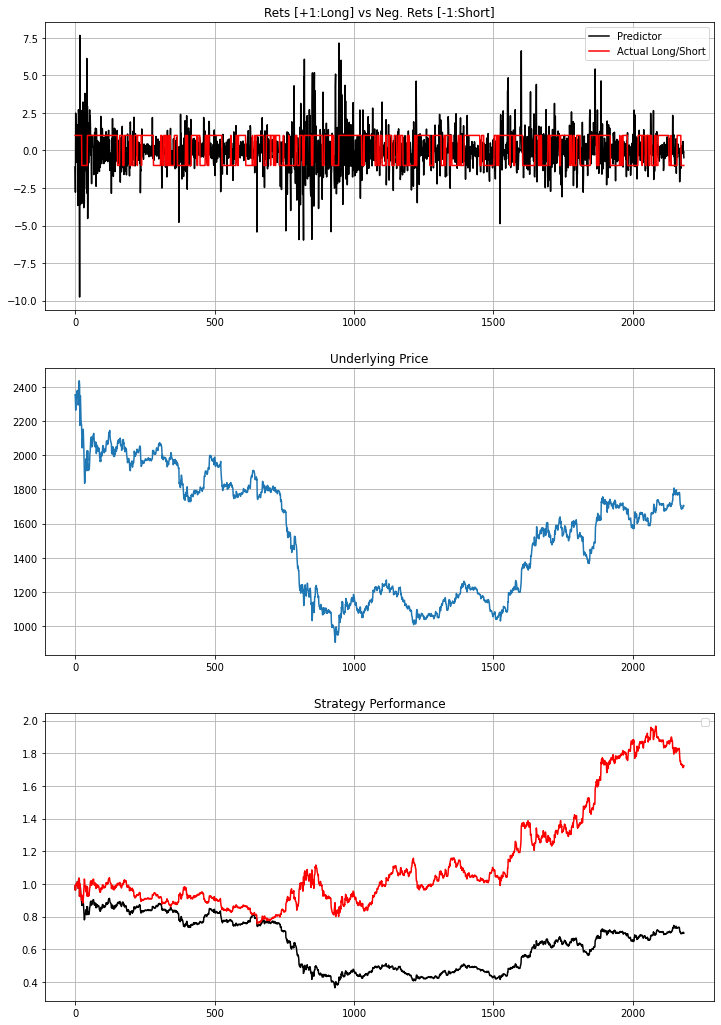

In [17]:
# Check model performance against market
PredictedY = model.predict(X_pred)
import copy
myTime = 13
PredictedY=PredictedY[-168*myTime:,0]

PredictedY[PredictedY>0] = 1
PredictedY[PredictedY<0] = -1

ActualY = copy.deepcopy(InputData.WasUp.values[-168*myTime:])

c=0
print('predictedY',np.shape(PredictedY))
print('actualY',np.shape(ActualY))

Strategy = np.array([num1*num2 for num1, num2 in zip(ActualY[:], PredictedY[:])])

Omniscience = sum(Strategy)/sum(abs(ActualY))
print('Strategy Omniscience: ', Omniscience) 
for i in range(len(PredictedY)):
  if (PredictedY[i] >= 0 and ActualY[i] >= 0) or (PredictedY[i] < 0 and ActualY[i] < 0):
    c+=1
print(np.round_(100*c/len(PredictedY),3),'% Accurate')

fig = plt.gcf()
fig.set_size_inches(12, 18)
plt.subplot(3,1,1)
plt.plot(100*ActualY[-myTime*168:],'k')
plt.plot(PredictedY[-myTime*168:],'r')
plt.grid()
plt.legend(['Predictor','Actual Long/Short'])
plt.title('Rets [+1:Long] vs Neg. Rets [-1:Short]')

PredictedY = PredictedY[-myTime*168:]
ActualY = copy.deepcopy(InputData.WasUp[-myTime*168:].values)

plt.subplot(3,1,2)
plt.title('Underlying Price')
plt.plot(InputData.close.values[-myTime*168:])
plt.grid()
# plt.title('Cum. Returns of All 12hr holding periods')
plt.subplot(3,1,3)
plt.title('Strategy Performance')
plt.plot(np.cumprod(1+ActualY),'k')
plt.plot(np.cumprod(1+Strategy),'r')
plt.legend('Actual','Strategy')
plt.grid()


print('All Returns: ', 100*sum(Strategy)/periods,'%')
# print('Average Returns: ', 100*np.mean(ActualY),'%')
print('Average Win:', 100*np.mean(Strategy[Strategy >= 0]),'%')
print('Average Loss:', 100*np.mean(Strategy[Strategy < 0]),'%')
prob = np.round_(100*c/len(PredictedY),3)
ExpRet = (prob*np.mean(Strategy[Strategy >= 0]) + (1-prob)*np.mean(Strategy[Strategy < 0]))
print("Exp. Ret:", ExpRet,'%')
print("Sharpe's Ratio:", (sum(Strategy)/len(Strategy))/(np.std(Strategy)))

### Observations:

We have trained two models that run the same input data.
The models predict directional positions for trading the Ethereum cryptocurrency.
The first model is considerably more simplistic than the second model.
Notable changes between the first and second model are additional LSTM layers,
more neurons and a custom loss function.

The results of the second model exceed those of the first model.
The second model has a cumulative sum return of ~70% whereas the first model has only ~24%.
 Both models greatly outperform the strategy of simply holding Ethereum  (~30% loss) and never taking short positions with the currency.


### Conclusion

Bidirectional LSTM is one approach to model time series data.
We have built a model that takes sequential timeseries data for a cryptocurrency and makes predictions of whether the asset will go up or down.
We have observed that model performance iscreases when we deploy a custom loss function vs.
 a standard MSE loss function.

Opportunities for future work and improvement should involve fine tuning inout data through feature engineering and additional technical indicators. Furthermore, some features can be dropped altogether. In the past, I have looked at residual connections within the LSTM to improve performance; this is an area that may be fruitful.

One very interesting area of research that I intend on tailing this model toward is reinforcement neural networks or even adversarial networks.